In [1]:
#!pip install torch==1.10

# Urinary system diseases classification
#### Presumptive classification of nephritis from inflammation

This notebook aims to create a classification model for the dataset described in here https://www.kaggle.com/yamqwe/acute-inflammationse


```
Credit:
Jacek Czerniak, Ph.D., Assistant ProfessorSystems Research InstitutePolish Academy of SciencesLaboratory of Intelligent Systems ul. Newelska 6, Room 21801-447 Warszawa, Polande-mail:
jacek.czerniak '@' ibspan.waw.pl or jczerniak '@' ukw.edu.pl
```

In [2]:
import pandas as pd

In [3]:
data_file = 'data/diagnosis.data'
columns = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing (continuous need for urination)', 'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet', 'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']
data_df = pd.read_csv(filepath_or_buffer=data_file, sep='\t', header=None, names=columns, encoding='utf-16')
data_df.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no


## Feature engineering

### Drop missing values

In [4]:
data_df.shape

(120, 8)

In [5]:
data_df = data_df.dropna(axis=0)
data_df.shape

(120, 8)

There are no missing values

### Convert text to numbers

In [6]:
for c in columns[1:]:
    data_df.loc[data_df[c]=='no',c] = 0
    data_df.loc[data_df[c]=='yes',c] = 1
data_df.head()


,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,"35,5",0,1,0,0,0,0,0
1,"35,9",0,0,1,1,1,1,0
2,"35,9",0,1,0,0,0,0,0
3,"36,0",0,0,1,1,1,1,0
4,"36,0",0,1,0,0,0,0,0


### Create labels  

- Check if one patient can have both diseases

In [7]:
data_df[(data_df['Inflammation of urinary bladder'] == 1) & (data_df['Nephritis of renal pelvis origin'] == 1)].shape

(19, 8)

- Check if one patient don't have any disease

In [8]:
data_df[(data_df['Inflammation of urinary bladder'] == 0) & (data_df['Nephritis of renal pelvis origin'] == 0)].shape

(30, 8)

Create a Diagnosis column which will serve as our label. It can have values of
- 0 : if patient has no disease
- 1 : if patient was diagnosed with just "Nephritis of renal pelvis origin"
- 2 : if patient was diagnosed with just "Inflammation of urinary bladder"
- 3 : if patient was diagnosed with both diseases

In [9]:
import numpy as np

In [10]:
conditions = [
    ((data_df['Inflammation of urinary bladder'] ==
     0) & (data_df['Nephritis of renal pelvis origin'] == 0)),
    ((data_df['Inflammation of urinary bladder'] ==
     0) & (data_df['Nephritis of renal pelvis origin'] == 1)),
    ((data_df['Inflammation of urinary bladder'] ==
     1) & (data_df['Nephritis of renal pelvis origin'] == 0)),
    ((data_df['Inflammation of urinary bladder'] ==
     1) & (data_df['Nephritis of renal pelvis origin'] == 1))
]
values = [0, 1, 2, 3]
data_df['Diagnosis'] = np.select(conditions, values)
data_df.head()


,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Inflammation of urinary bladder,Nephritis of renal pelvis origin,Diagnosis
0,"35,5",0,1,0,0,0,0,0,0
1,"35,9",0,0,1,1,1,1,0,2
2,"35,9",0,1,0,0,0,0,0,0
3,"36,0",0,0,1,1,1,1,0,2
4,"36,0",0,1,0,0,0,0,0,0


### Drop previous diagnosis columns

In [11]:
data_df = data_df.drop(['Inflammation of urinary bladder', 'Nephritis of renal pelvis origin'], axis=1)
data_df.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Diagnosis
0,"35,5",0,1,0,0,0,0
1,"35,9",0,0,1,1,1,2
2,"35,9",0,1,0,0,0,0
3,"36,0",0,0,1,1,1,2
4,"36,0",0,1,0,0,0,0


### Scale temperature

Convert temperature decimal character

In [12]:
data_df['Temperature of patient'] = data_df['Temperature of patient'].str.replace(',','.')
data_df.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Diagnosis
0,35.5,0,1,0,0,0,0
1,35.9,0,0,1,1,1,2
2,35.9,0,1,0,0,0,0
3,36.0,0,0,1,1,1,2
4,36.0,0,1,0,0,0,0


In [13]:
data_df = data_df.astype({'Temperature of patient':'float',
        'Occurrence of nausea':'float',
        'Lumbar pain':'float',
        'Urine pushing (continuous need for urination)':'float',
        'Micturition pains':'float',
        'Burning of urethra, itch, swelling of urethra outlet':'float',
        'Diagnosis':'category',
})
data_df.dtypes

Temperature of patient                                   float64
Occurrence of nausea                                     float64
Lumbar pain                                              float64
Urine pushing (continuous need for urination)            float64
Micturition pains                                        float64
Burning of urethra, itch, swelling of urethra outlet     float64
Diagnosis                                               category
dtype: object

In [14]:
data_df: pd.DataFrame
data_df.describe(include='all')

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Diagnosis
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,4.0
top,NaN,NaN,NaN,NaN,NaN,NaN,2.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,40.0
mean,38.724167,0.241667,0.583333,0.666667,0.491667,0.416667,NaN
std,1.819132,0.429888,0.495074,0.473381,0.502027,0.495074,NaN
min,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,37.100000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,37.950000,0.000000,1.000000,1.000000,0.000000,0.000000,NaN
75%,40.600000,0.000000,1.000000,1.000000,1.000000,1.000000,NaN


### Data exploration

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

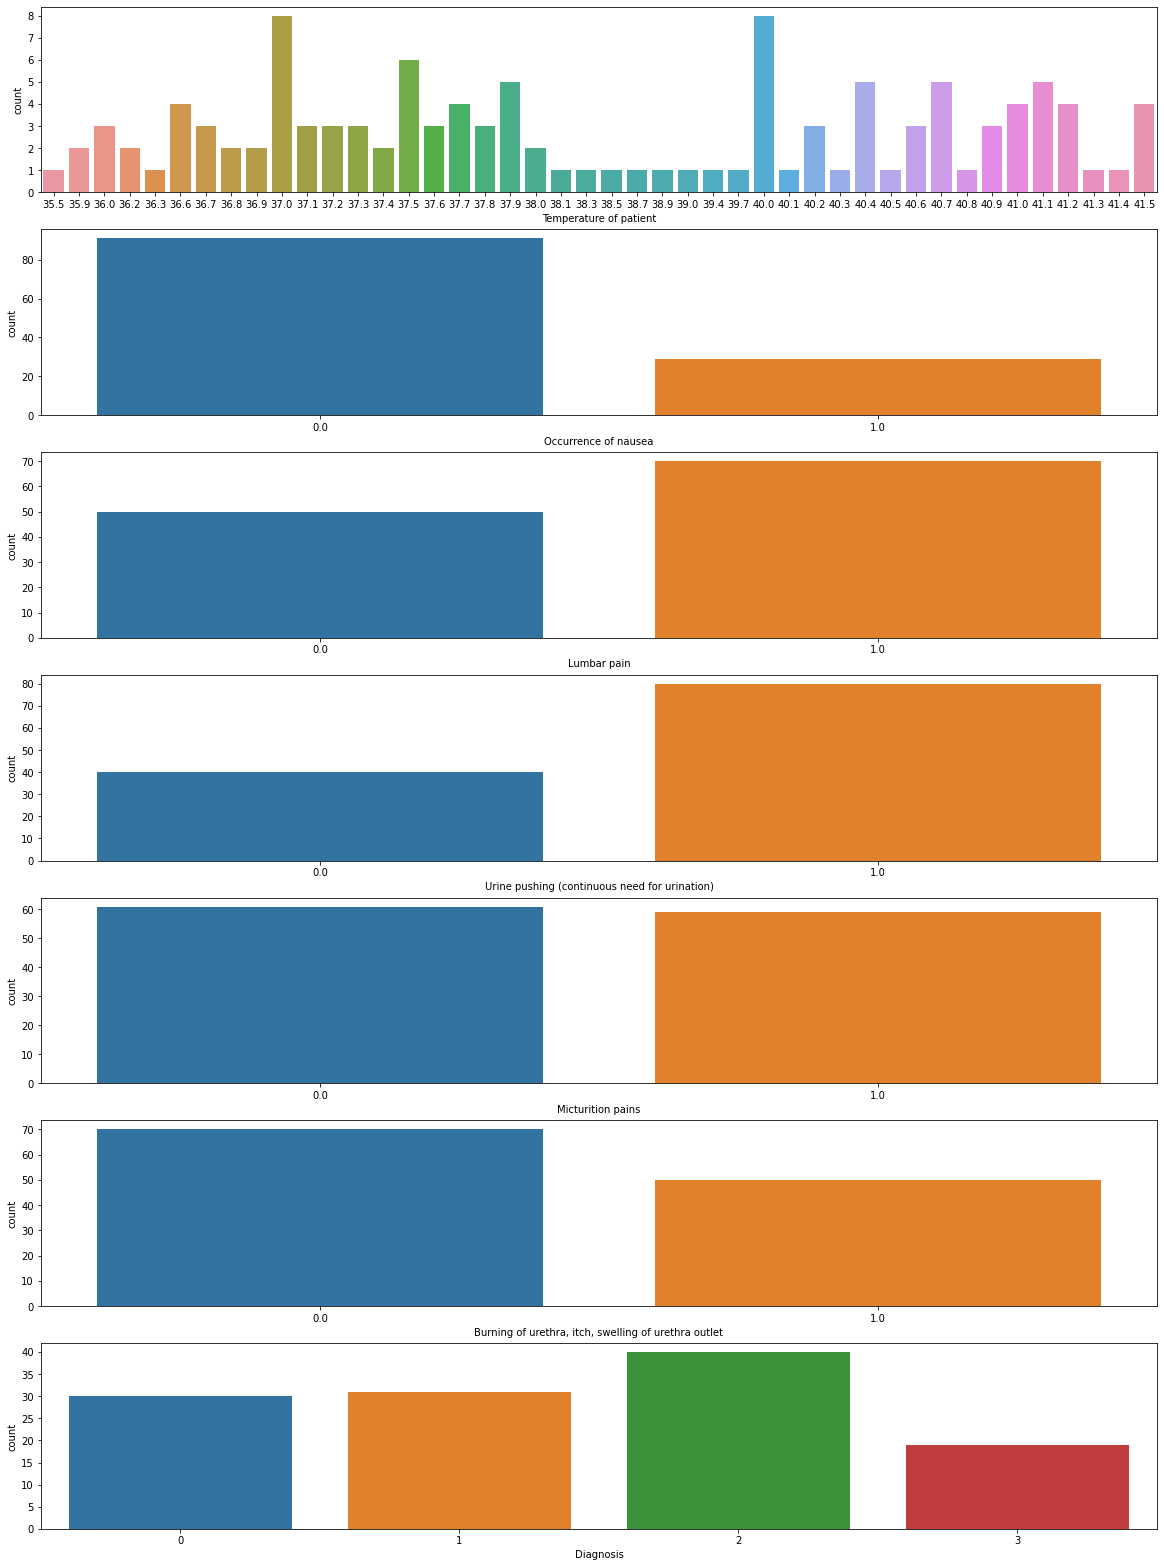

In [16]:
fig, ax =plt.subplots(len(data_df.columns),1, figsize=(20,4*len(data_df.columns)))
for i, c in enumerate(data_df.columns):
    sns.countplot(data=data_df, x=c, ax=ax[i])
fig.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
data_df[['Temperature of patient']]=pd.DataFrame(scaler.fit_transform(data_df[['Temperature of patient']].astype(float)))
data_df.head()


,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Diagnosis
0,0.000000,0.0,1.0,0.0,0.0,0.0,0
1,0.066667,0.0,0.0,1.0,1.0,1.0,2
2,0.066667,0.0,1.0,0.0,0.0,0.0,0
3,0.083333,0.0,0.0,1.0,1.0,1.0,2
4,0.083333,0.0,1.0,0.0,0.0,0.0,0


In [18]:
from pickle import dump
import os
os.makedirs('model',exist_ok=True)
dump(scaler, open('model/scaler.pkl', 'wb'))

In [19]:
def one_hot_diagnosis(df, d):
    conditions = [
        ((df['Diagnosis']==d)),
        ((df['Diagnosis']!=d)),
    ]
    values = [1, 0]
    df['D'+str(d)] = np.select(conditions, values)
    return df

In [20]:
data_df=one_hot_diagnosis(data_df, 0)
data_df=one_hot_diagnosis(data_df, 1)
data_df=one_hot_diagnosis(data_df, 2)
data_df=one_hot_diagnosis(data_df, 3)

In [21]:
data_df.dtypes

Temperature of patient                                   float64
Occurrence of nausea                                     float64
Lumbar pain                                              float64
Urine pushing (continuous need for urination)            float64
Micturition pains                                        float64
Burning of urethra, itch, swelling of urethra outlet     float64
Diagnosis                                               category
D0                                                         int64
D1                                                         int64
D2                                                         int64
D3                                                         int64
dtype: object

<AxesSubplot:>

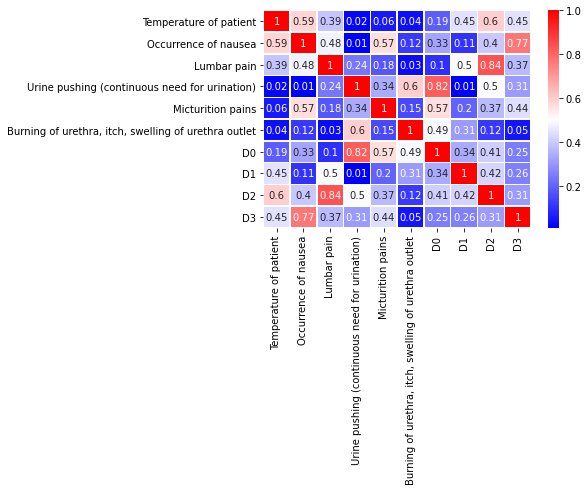

In [22]:
corr_matrix = data_df.corr().abs().round(2)
sns.heatmap(corr_matrix, annot=True, cmap='bwr', linewidths=.5)

In [23]:
test_ratio = 0.2
test_index = int(data_df.shape[0]*(1-test_ratio))
train_df = data_df[:test_index]
test_df = data_df[test_index:]
train_X, train_Y = train_df[train_df.columns[:-5]], train_df[train_df.columns[-4:]]
test_X, test_Y = test_df[test_df.columns[:-5]], test_df[test_df.columns[-4:]]

In [24]:
import torch

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# device = torch.device("cpu")
# device

device(type='cpu')

In [26]:
from model.model110 import LinearModelDisease
INPUT_DIM = train_X.shape[1]
HIDDEN_DIM = train_X.shape[1]*4
OUTPUT_DIM = train_Y.shape[1]
model = LinearModelDisease(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device)

LinearModelDisease(
  (fc1): Linear(in_features=6, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [27]:
import torch.optim as optim
import torch.nn as nn
LINEAR_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LINEAR_RATE)
criterion = nn.CrossEntropyLoss()

In [28]:
EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for x, y in zip(train_X.values, train_Y.values):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)
        optimizer.zero_grad()
        log_ps = model.forward(x)
        ps = torch.exp(log_ps)
        loss = criterion(ps[0].view(-1, OUTPUT_DIM), y.view(-1, OUTPUT_DIM))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    else:
        model.eval()
        with torch.no_grad():
            accuracy = 0
            test_loss = 0
            for x, y in zip(test_X.values, test_Y.values):
                x = torch.tensor(x).float().to(device)
                y = torch.tensor(y).float().to(device)
                log_ps = model.forward(x)
                ps = torch.exp(log_ps)
                test_loss += criterion(ps[0].view(-1, OUTPUT_DIM), y.view(-1, OUTPUT_DIM)).item()
                top_p, top_class = ps.topk(1, dim=1)
                accuracy += int(y.argmax().item()==ps.argmax().item())

        print(f'Epoch: {epoch}',
        f' Train Loss: {total_loss/len(train_Y.values):.2f}',
        f' Test Loss: {test_loss/len(test_Y.values):.2f}',
        f' Accuracy: {accuracy/len(test_Y.values):.2f}'
        , end='\r')

In [29]:
for x, y in zip(test_X.values, test_Y.values):
    x = torch.tensor(x).float().to(device)
    y = torch.tensor(y).float().to(device)
    log_ps = model.forward(x)
    ps = torch.exp(log_ps)
    print(f'y={y.argmax().item()} ps={ps.argmax().item()}')


y=1 ps=1
y=1 ps=1
y=3 ps=3
y=3 ps=3
y=1 ps=1
y=3 ps=3
y=0 ps=0
y=1 ps=1
y=1 ps=1
y=3 ps=3
y=3 ps=3
y=0 ps=0
y=1 ps=1
y=1 ps=1
y=3 ps=3
y=0 ps=0
y=1 ps=1
y=1 ps=1
y=3 ps=3
y=1 ps=1
y=0 ps=0
y=1 ps=1
y=1 ps=1
y=1 ps=1


In [30]:
from pickle import dump
import os
os.makedirs('model',exist_ok=True)
dump(model, open('model/model_1.10.pkl', 'wb'))